# Roman-Cuts

A short tutorial on how to use `RomanCuts` to get cutouts from simulated images created with `RImTimSim` [Link](https://github.com/robertfwilson/rimtimsim).

In [20]:
import os
import numpy as np
from glob import glob
from roman_cuts import RomanCuts
import matplotlib.pyplot as plt
import asdf

In [21]:
PATH = "../data/dryrun_01"

FILTER = "F087"
SCA = 2
FIELD = 3

In [22]:
# get path for all FITS files in disk
ff = f"{PATH}/simulated_imgs/rimtimsim_WFI_lvl02_{FILTER}_SCA{SCA:02}_field{FIELD:02}_rampfitted_r1920c1920_256x256_sim.asdf"
os.path.isfile(ff)

True

In [23]:
# initialize RomanCuts object
rcube = RomanCuts(field=FIELD, sca=SCA, filter=FILTER, file_list=ff, file_format="asdf")
print(f"Pixel Column range {rcube.column_min_data} : {rcube.column_max_data}")
print(f"Pixel Row    range {rcube.row_min_data} : {rcube.row_max_data}")
rcube

Pixel Column range 1792 : 2048
Pixel Row    range 1792 : 2048


Roman WFI Field 3 SCA 2 Filter F087 Frames 132

## Fixed pixel coordinates

In [24]:
# make a cutout using pixel row and column coordinates
# with dithered=False the cutouts will be fixed tothe pixel grid
rcube.make_cutout(rowcol=(1820, 2000), size=(21, 21), dithered=False)

In [25]:
# this is the center of the cutout 
rcube.ra, rcube.dec

(array(268.48975256), array(-29.20246711))

In [26]:
# we have the flux and errors in 3d arrays
rcube.flux.shape, rcube.flux_err.shape

((132, 21, 21), (132, 21, 21))

In [27]:
# we have the time, cadence numbe and quality flags
rcube.time.shape, rcube.exposureno.shape, rcube.quality.shape

((132,), (132,), (132,))

In [28]:
# and the metadata
rcube.metadata

{'CREATOR': 'TRExS-roman-cuts',
 'DEC_CEN': -29.20603569593083,
 'DETECTOR': 'SCA02',
 'DITHERED': False,
 'EQUINOX': 2000.0,
 'EXPOSURE': 54.72,
 'FIELD': 3,
 'FILTER': 'F087',
 'IMGSIZE': [256, 256],
 'MISSION': 'Roman-Sim',
 'NTIMES': 132,
 'RADESYS': 'FK5',
 'RA_CEN': 268.49141932159233,
 'READMODE': 'rampfitted',
 'SOFTWARE': 'rimtimsim_v2.0',
 'TELESCOP': 'Roman',
 'TEND': 2461520.3880308005,
 'TSTART': 2461450.751698133}

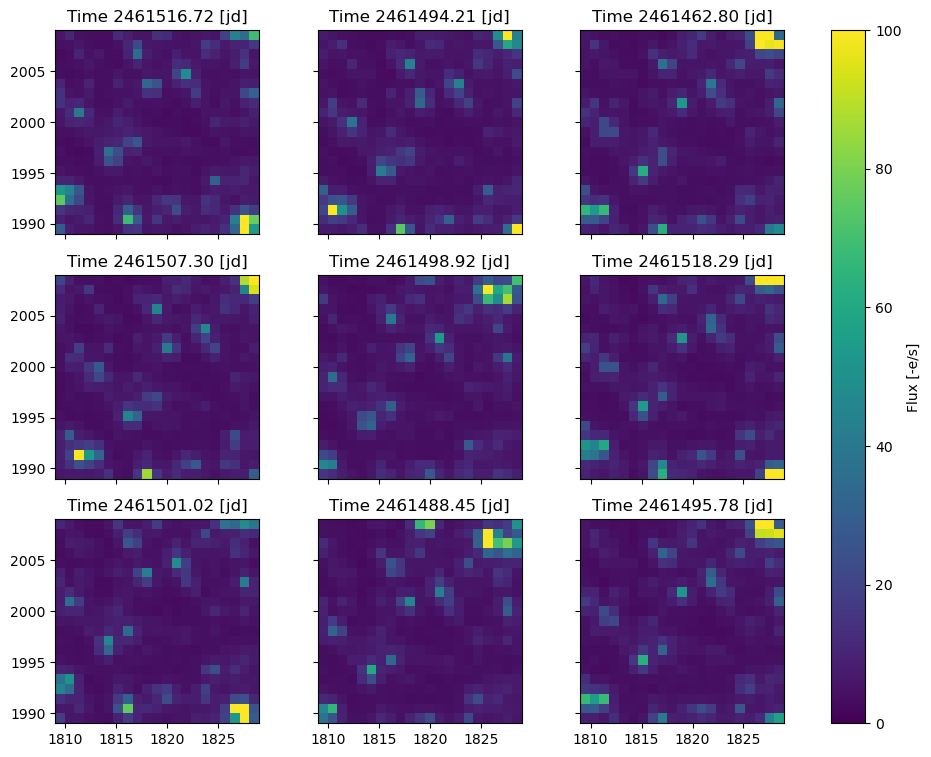

In [29]:
# we can check a few stamps

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(12,9))
tdx = np.random.choice(np.arange(rcube.nt), size=9, replace=False)
for axis, t in zip(ax.ravel(), tdx):
    bar = axis.imshow(rcube.flux[t], 
                origin="lower", 
                vmin=0, 
                vmax=100, 
                extent=(rcube.row.min(), rcube.row.max(), rcube.column.min(), rcube.column.max()),
               )
    axis.set_title(f"Time {rcube.time[t]:.2f} [jd]")
plt.colorbar(bar, ax=ax, location="right", label="Flux [-e/s]" )
plt.show()

## Accounting for Dithering

In [30]:
# we can use sky coordinates to center the cutout
# the target will be centeredaccounting for dithering
radec = (268.48744213, -29.2076513)

In [31]:
# we can request all WCSs, it will take a few seconds more
rcube.make_cutout(radec=radec, size=(15, 15), dithered=True)

In [32]:
rcube.flux.shape

(132, 15, 15)

In [33]:
# this time row and columns are [nt, npix]
rcube.row, rcube.column

(array([[1841, 1842, 1843, ..., 1853, 1854, 1855],
        [1840, 1841, 1842, ..., 1852, 1853, 1854],
        [1840, 1841, 1842, ..., 1852, 1853, 1854],
        ...,
        [1840, 1841, 1842, ..., 1852, 1853, 1854],
        [1841, 1842, 1843, ..., 1853, 1854, 1855],
        [1841, 1842, 1843, ..., 1853, 1854, 1855]]),
 array([[1805, 1806, 1807, ..., 1817, 1818, 1819],
        [1807, 1808, 1809, ..., 1819, 1820, 1821],
        [1805, 1806, 1807, ..., 1817, 1818, 1819],
        ...,
        [1808, 1809, 1810, ..., 1820, 1821, 1822],
        [1805, 1806, 1807, ..., 1817, 1818, 1819],
        [1807, 1808, 1809, ..., 1819, 1820, 1821]]))

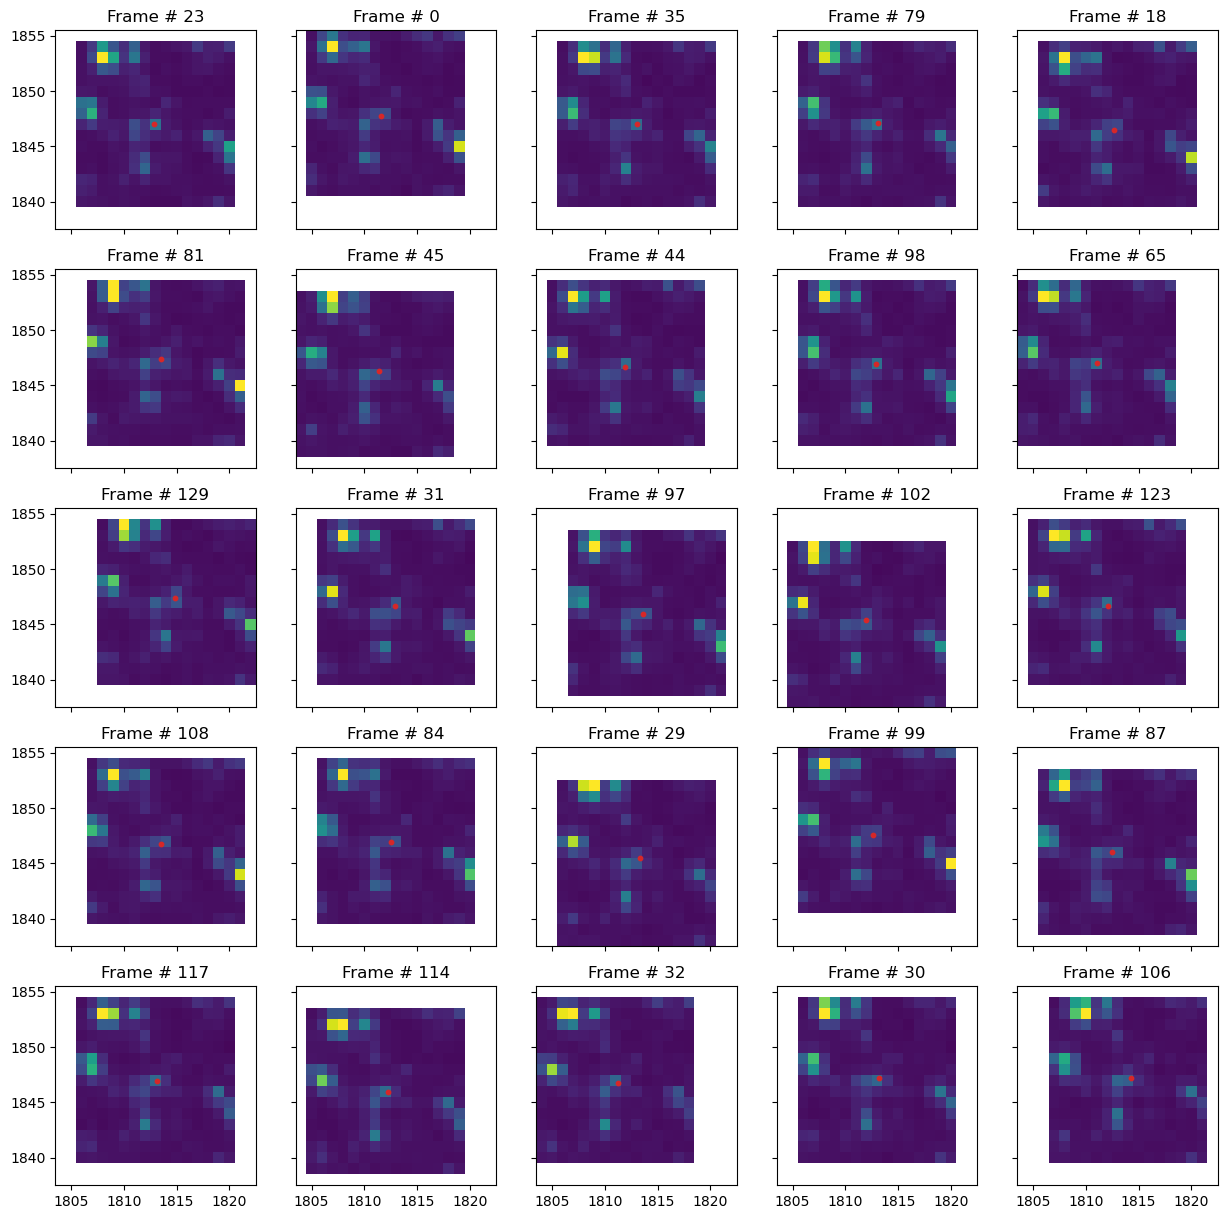

In [34]:
# visual check of the cutouts centered in the target
Ts = np.random.choice(np.arange(rcube.nt), size=5*5, replace=False)

fig, ax = plt.subplots(5,5,figsize=(15,15),sharex=True, sharey=True)
for t, axis in zip(Ts, ax.ravel()):
    axis.pcolormesh(rcube.column[t], rcube.row[t], rcube.flux[t], vmin=0, vmax=100)
    axis.scatter(rcube.target_pixel[t, 1],rcube.target_pixel[t, 0], c="tab:red", s=10)
    axis.set_title(f"Frame # {t}")
plt.show()

In [17]:
# we can save the file to disk with default name
rcube.save_cutout()

In [18]:
# this one contains all the WCS per frame in the ASDF
af = asdf.open("./roman_cutout_field03_SCA02_268.4874_-29.2077_s15x15.asdf")
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 5.0.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata) ...
│   └─[1] (ExtensionMetadata) ...
└─roman (dict)
  ├─data (dict)
  │ ├─column (NDArrayType) ...
  │ ├─exposureno (NDArrayType) ...
  │ ├─flux (NDArrayType) ...
  │ ├─flux_err (NDArrayType) ...
  │ ├─quality (NDArrayType) ...
  │ ├─row (NDArrayType) ...
  │ └─time (NDArrayType) ...
  ├─meta (dict)
  │ ├─CREATOR (str): TRExS-roman-cuts
  │ └─17 not shown
  └─wcs (list) ...
Some nodes not shown.


In [19]:
# row and column in the ASDF have the lower-left corner pixel for each time
# we can reconstruct the pixel grid at each time with that and the cutout size.
af["roman"]["data"]["row"], af["roman"]["data"]["column"]

(<array (unloaded) shape: [132] dtype: int64>,
 <array (unloaded) shape: [132] dtype: int64>)